In [257]:
import cortx_community as cc
import cortx_graphing as cg
from github import Github  # https://pygithub.readthedocs.io/
import github
import pickle
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import requests
from IPython.display import Markdown, display, Pretty, Latex, HTML

%matplotlib inline

In [258]:
#####################
# helper functions  #
#####################

def Verbose(String):
    v = False
    if v:
        print(String) 

# we want to make 4 graphs comparing all the repos:
# comparing age of each open issue
# comparing latency of each open issue
# comparing age of each open pull request
# comparing latency of each open pull request
def get_stats_structure():
    stats = {}
    for repo in repos:
        stats[repo.name] = {}
        for Type in ('issues','pullrequests'):
            for metric in ('age','latency'):
                stats[repo.name]['%s_%s' % (Type,metric)] = []
    return(stats)

def get_response_latency_and_age_in_days(issue):
    birth=issue.created_at
    age = (datetime.utcnow() - birth).total_seconds()
    latency = age # in case there are no good comments, just use age
    for comment in issue.get_comments():
        if '[bot]' not in comment.user.login:
            latency = (comment.created_at - birth).total_seconds()
            break
    return(latency/86400.0,age/86400.0)
        
def get_type(issue):
    if issue.pull_request is None:
        Type="issues"
    else:
        Type="pullrequests"
    return Type

def get_gh_metrics(repo,issues,stats):
    Verbose("Getting metrics for %s" % repo)
    for issue in issues[repo]:
        cc.avoid_rate_limiting(gh,10,False)
        (lat,age) = get_response_latency_and_age_in_days(issue)
        Type = get_type(issue)
        stats[repo]['%s_latency' % Type].append(lat)
        stats[repo]['%s_age' % Type].append(age)

def make_bar_graph(config,repos):
    #set seaborn plotting aesthetics
    sns.set(style='white')
    sns.set(font_scale = 2)

    #create grouped bar chart
    ordering = sorted(repos)
    g = sns.barplot(x=config['x'], y=config['y'], hue=config['hue'], data=config['df'], order=ordering) 
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set(xlabel=None) # remove xlabel
    g.set(ylabel=None) # and ylabel
    g.axes.set_title(config['title'])
    #g.tick_params(labelsize=16)

    # remove title from legend
    handles, labels = g.get_legend_handles_labels()
    g.legend(handles=handles[0:], labels=labels[0:])
    return g

def make_boxplot(metric,title,ylabel):
    fontsize=16
    df = pd.DataFrame(
        columns=[metric,'repo'])
    for repo in repos:
        for value in stats[repo.name][metric]:
            df.loc[len(df.index)] = [value,repo.name]
    ordering = sorted([repo.name for repo in repos])
    bplot=sns.boxplot(y=metric, x='repo', 
                 data=df, 
                 width=0.75,
                 order=ordering,
                 palette="colorblind")
    bplot=sns.stripplot(y=metric, x='repo',
              data=df, 
              order=ordering,
              color='black',
              alpha=0.75)
    
    bplot.axes.set_title(title,fontsize=16)
    bplot.set(xlabel=None)
    bplot.set_ylabel(ylabel,fontsize=fontsize)
    bplot.tick_params(labelsize=16)
    bplot.set_xticklabels(bplot.get_xticklabels(),rotation=90)
    return bplot

def get_codacy(url,data=None):
    codacy_url=url
    oath=os.getenv('CODACY_OATH')
    headers={"api-token":oath, "Accept":"application/json"}
    #print(oath)
    if data:
        headers['Content-Type'] = 'application/json'
        r = requests.post(codacy_url, headers=headers, data=data)
    else:
        r = requests.get(codacy_url, headers=headers)
    #print(r)
    #print(r.url)
    #r.text
    return r


In [259]:
###########################
# codacy helper functions #
###########################

def check_security(repo):
    url=codacy_base + "/%s/issues/search" % repo
    data={}
    data['levels'] = ["Error", "Warning"]
    data["categories"] = ["Security"]
    response = get_codacy(url=url,data=json.dumps(data))
    warnings = 0
    errors = 0
    for i in response.json()['data']:
        if i['patternInfo']['level'] == 'Warning':
            warnings += 1
        elif i['patternInfo']['level'] == 'Error':
            errors += 1
        else:
            Verbose('wtf? unknown severity level in repo %s' % repo)
    return(warnings,errors)

def get_codacy_stats(repo):
    def set_metric(metric,metrics,Json):
        metrics[metric] = Json['data'][metric]
    url="%s/%s" % (codacy_base, repo)
    response = get_codacy(url=url)
    Json = response.json()
    local_metrics = {}
    #print(Json['data']['coverage'])
    for m in ['grade', 'issuesPercentage', 'complexFilesPercentage', 'duplicationPercentage']:
        try:
            set_metric(m,local_metrics,Json)
        except KeyError:
            Verbose("WTF: No value for %s in repo %s" % (m,r))
    coverage=Json['data']['coverage']
    local_metrics['coverage'] = 100 * (1.0 * (coverage['numberTotalFiles']-coverage['filesUncovered'])) / coverage['numberTotalFiles']
    return (local_metrics,Json)

In [260]:
##################
# Initialization #
##################

gh = Github(os.environ.get('GH_OATH'))
cc.avoid_rate_limiting(gh,10,False)

repos=[]
repos=cc.get_repos(None,'Seagate','cortx')
rnames = [r.name for r in repos]
Verbose("CORTX Repos: %s" % ", ".join(rnames))

# Set global values for seaborn
sns.set(rc = {'figure.figsize':(15,8)})


In [261]:
#########################
# scrape github metrics #
#########################

issues={}
for r in repos:
    issues[r.name]=[]
    for i in r.get_issues(state='open'):
        issues[r.name].append(i)
    Verbose("Fetched %d open issues for %s" % (len(issues[r.name]), r.name))

stats = get_stats_structure() # initialize the structure
for repo in repos:
    get_gh_metrics(repo.name,issues,stats)
    
# scrape github to get the branch count for each repo
for r in repos:
    branches = r.get_branches()
    stats[r.name]['branch_count'] = branches.totalCount
    # blech, seems to be no way to get the age of a branch...
    #stats[r.name]['branches_age'] = []
    #for b in branches:
    #    print(b.commit.commit.html_url)
    #    age = ((datetime.utcnow() - b.created_at).total_seconds()) / 86400
    #    stats[r.name]['branches_age'].append(age)
    Verbose("Repo %s has %d branches" % (r.name, stats[r.name]['branch_count']))

In [262]:
#########################
# scrape codacy metrics #
#########################

codacy_base='https://app.codacy.com/api/v3/analysis/organizations/gh/Seagate/repositories'
response=get_codacy(codacy_base)
#Verbose(response.json())

# get the list of all codacy repos
Json=response.json()
if Json['pagination']['total'] >= Json['pagination']['limit']:
    print("Ugh. Have to deal with pagination.")
else:
    Verbose("Do not need to deal with pagination")
codacy_repos = []
for item in Json['data']:
    repo=item['repository']
    rname=repo['name']
    vis=repo['visibility']
    if 'cortx' in rname and vis == 'Public':
        codacy_repos.append(rname)
Verbose(", ".join(codacy_repos))

# now get metrics from each of them
codacy_metrics = {}
for r in codacy_repos:
    Verbose("Fetching codacy %s" % r)
    codacy_metrics[r]=get_codacy_stats(r)[0]
#print(metrics)

# now add security counts from codacy
for r in codacy_repos:
    (warnings,errors) = check_security(r)
    codacy_metrics[r]['security_warnings'] = warnings
    codacy_metrics[r]['security_errors'] = errors
    Verbose("repo %s security : %d warnings, %d errors" % (r, warnings, errors))

WTF: No value for complexFilesPercentage in repo cortx-nsal
WTF: No value for complexFilesPercentage in repo cortx-posix
WTF: No value for complexFilesPercentage in repo cortx-dsal
WTF: No value for complexFilesPercentage in repo cortx-motr-galois
WTF: No value for complexFilesPercentage in repo cortx-motr-apps


In [263]:
display(Markdown("<h1><center>%s</center></h1>" % "CORTX Repositories Health Report"))
today=datetime.today().strftime("%B %d, %Y")
display(Markdown("<h3>%s</h3>" % today))

<h1><center>CORTX Repositories Health Report</center></h1>

<h3>April 04, 2022</h3>

In [264]:
# let's try to create a single overall score for all repos
#print(stats.keys())
#print(codacy_metrics.keys())

#df = pd.DataFrame(columns=['Repo','Score','Type'])

#for r in repos:
#    repo = r.name
#    num_issues = len(stats[repo]['issues_age'])
#    num_prs = len(stats[repo]['pullrequests_age'])
#    df.loc[len(df.index)] = [repo,num_issues,'Open Issues']
#    df.loc[len(df.index)] = [repo,num_prs,'Open Pull Requests']

#print(df)

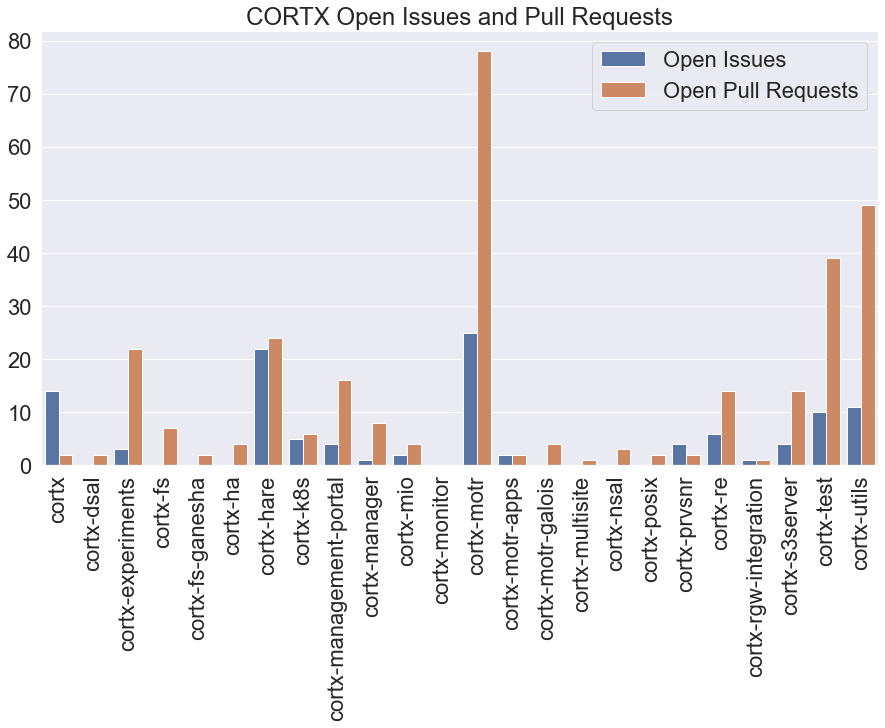

In [265]:
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in repos:
    repo = r.name
    num_issues = len(stats[repo]['issues_age'])
    num_prs = len(stats[repo]['pullrequests_age'])
    df.loc[len(df.index)] = [repo,num_issues,'Open Issues']
    df.loc[len(df.index)] = [repo,num_prs,'Open Pull Requests']

config={'x' : 'Repo', 'y' : 'Quantity', 'df' : df, 'hue' : 'Type', 'title' : "CORTX Open Issues and Pull Requests"}
rnames = [r.name for r in repos]
g = make_bar_graph(config,rnames)
plt.show()

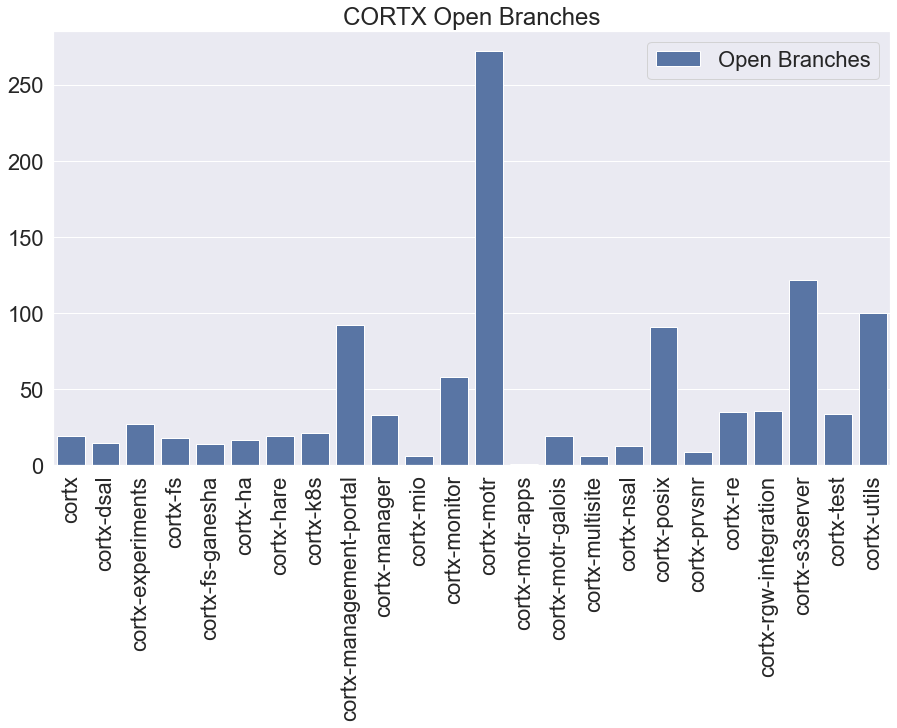

In [266]:
# make a bar graph for branch count
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in repos:
    repo = r.name
    num_branches = stats[r.name]['branch_count']
    df.loc[len(df.index)] = [repo,num_branches,'Open Branches']

config={'x' : 'Repo', 'y' : 'Quantity', 'df' : df, 'hue' : 'Type', 'title' : "CORTX Open Branches"}
rnames = [r.name for r in repos]
g = make_bar_graph(config,rnames)
plt.show()

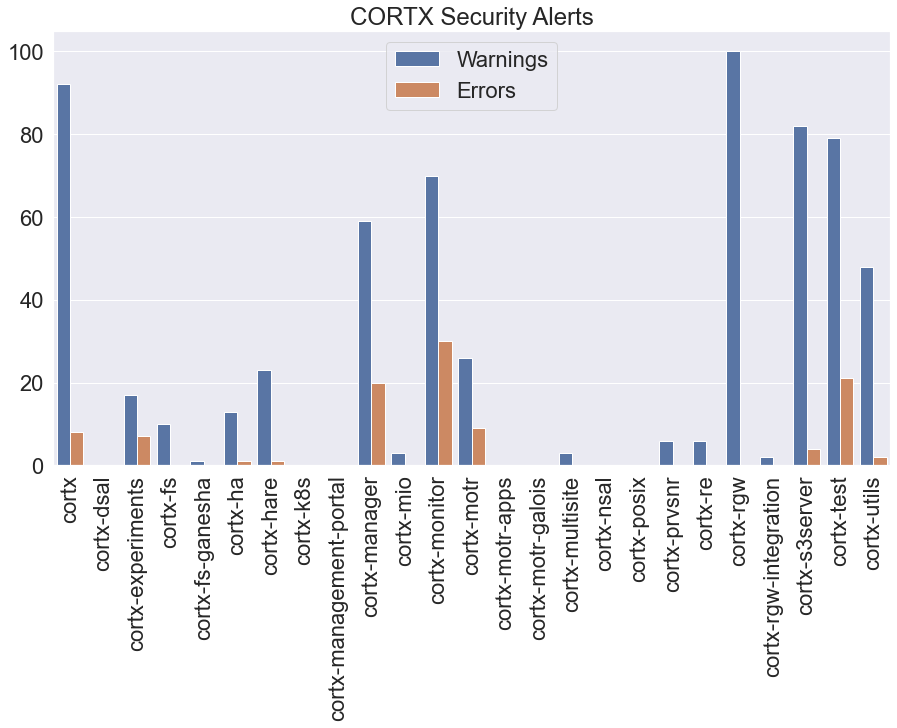

In [267]:
# make a bar chart for security
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in codacy_repos:
    repo = r
    sec_warn = codacy_metrics[r]['security_warnings']
    sec_err  = codacy_metrics[r]['security_errors']
    df.loc[len(df.index)] = [repo,sec_warn,'Warnings']
    df.loc[len(df.index)] = [repo,sec_err, 'Errors']

config={'x' : 'Repo', 'y' : 'Quantity', 'hue' : 'Type', 'title' : 'CORTX Security Alerts', 'df' : df}    
graph = make_bar_graph(config,codacy_repos)
plt.show()

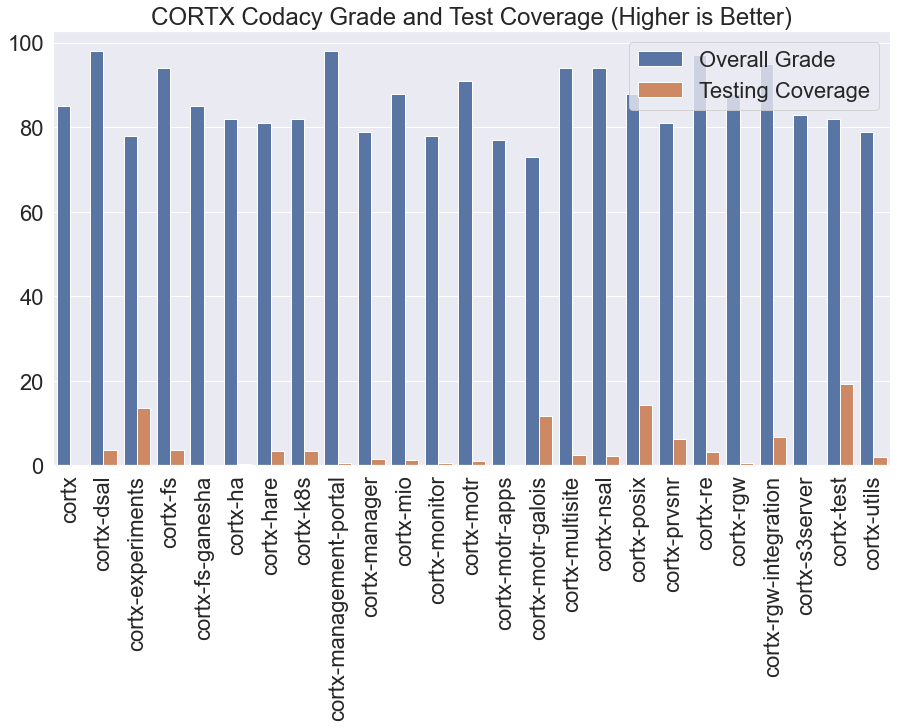

In [268]:
# make a bar chart for grade and coverage
df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in codacy_repos:
    grade = codacy_metrics[r]['grade']
    cover = codacy_metrics[r]['coverage']
    df.loc[len(df.index)] = [r,grade, 'Overall Grade']
    df.loc[len(df.index)] = [r,cover, 'Testing Coverage']

config={'x' : 'Repo', 'y' : 'Quantity', 'hue' : 'Type', 'title' : 'CORTX Codacy Grade and Test Coverage (Higher is Better)', 
        'df' : df}    
graph = make_bar_graph(config,codacy_repos)
plt.show()


#'grade', 'issuesPercentage', 'complexFilesPercentage', 'duplicationPercentage'


WTF: No value for complexFilesPercentage in repo cortx-nsal
WTF: No value for complexFilesPercentage in repo cortx-posix
WTF: No value for complexFilesPercentage in repo cortx-dsal
WTF: No value for complexFilesPercentage in repo cortx-motr-galois
WTF: No value for complexFilesPercentage in repo cortx-motr-apps


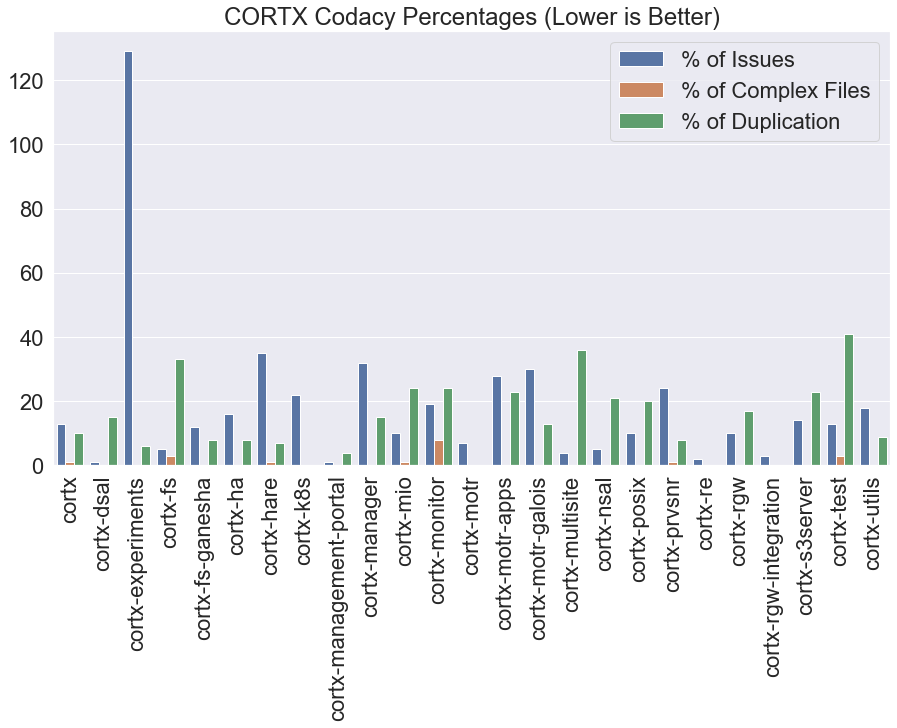

In [269]:
# make a bar chart for 'issuesPercentage', 'complexFilesPercentage', 'duplicationPercentage'
graph_metrics = { 'issuesPercentage' : '% of Issues', 
                  'complexFilesPercentage' : '% of Complex Files',
                  'duplicationPercentage' : '% of Duplication'
                }

df = pd.DataFrame(columns=['Repo','Quantity','Type'])
for r in codacy_repos:
    for k,label in graph_metrics.items():
        try:
            value = codacy_metrics[r][k]
            df.loc[len(df.index)] = [r, value, label]
        except KeyError:
            Verbose("WTF: No value for %s in repo %s" % (k, r))

config={'x' : 'Repo', 'y' : 'Quantity', 'hue' : 'Type', 'title' : 'CORTX Codacy Percentages (Lower is Better)', 
        'df' : df}    
graph = make_bar_graph(config,codacy_repos)
plt.show()


#'grade', 'issuesPercentage', 'complexFilesPercentage', 'duplicationPercentage'


In [270]:
display(Markdown("<h1><center>%s</center></h1>" % "More Detailed Breakdown of Issues and Pull Requests"))

<h1><center>More Detailed Breakdown of Issues and Pull Requests</center></h1>

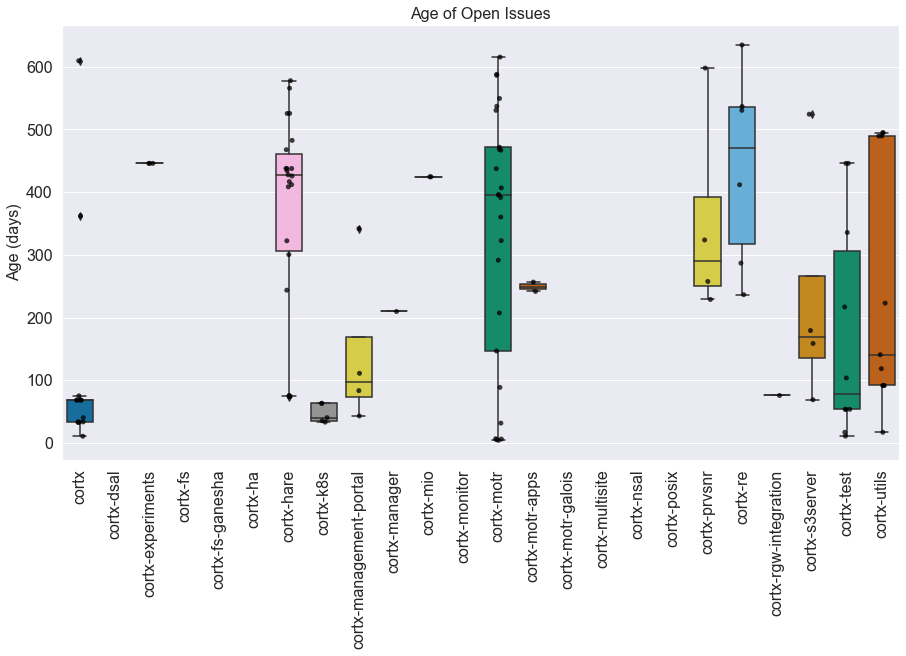

In [271]:
make_boxplot('issues_age','Age of Open Issues', 'Age (days)')
plt.show()

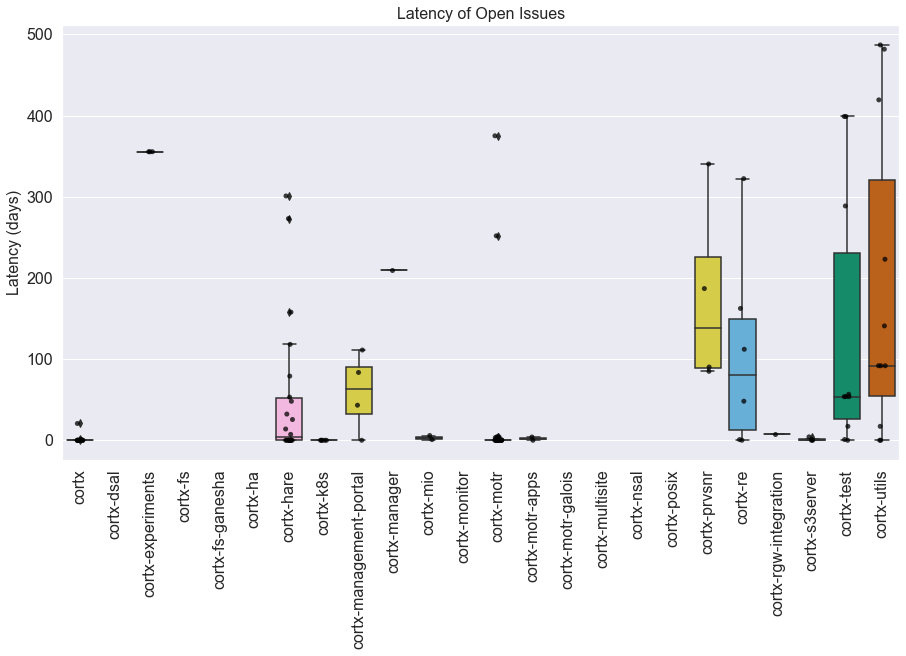

In [272]:
make_boxplot('issues_latency','Latency of Open Issues', 'Latency (days)')
plt.show()

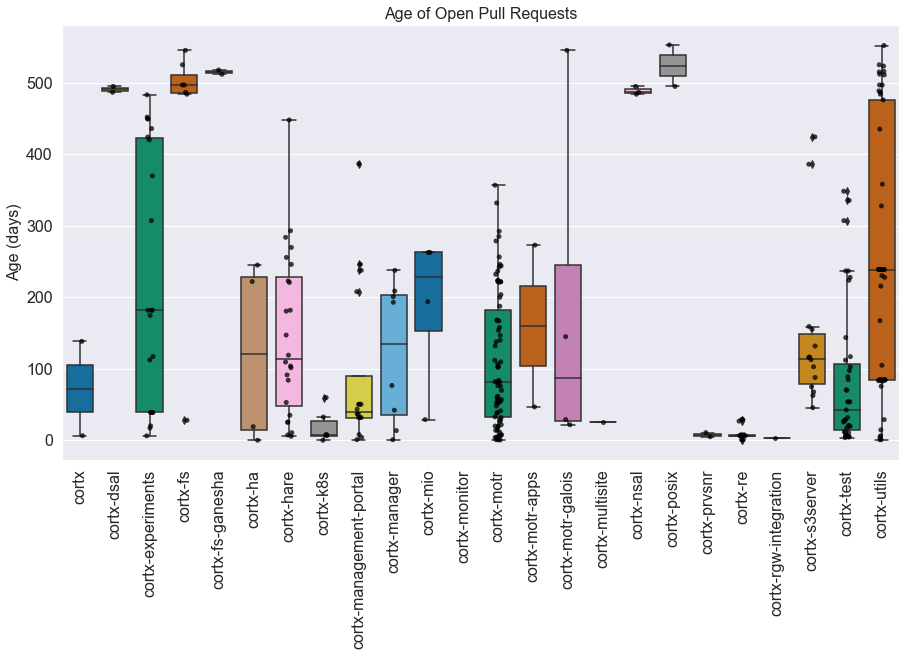

In [273]:
make_boxplot('pullrequests_age','Age of Open Pull Requests', 'Age (days)')
plt.show()

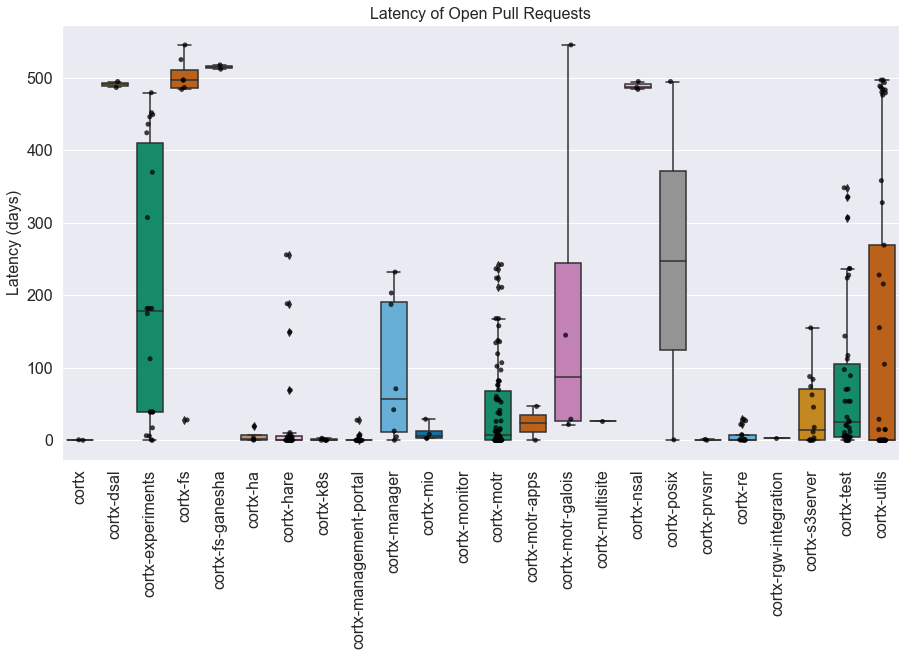

In [274]:
make_boxplot('pullrequests_latency','Latency of Open Pull Requests', 'Latency (days)')
plt.show()